<img src="https://avatars.githubusercontent.com/u/74911464?s=200&v=4"
     alt="OpenEO Platform logo"
     style="float: left; margin-right: 10px;" />
# OpenEO Platform - User Story 2
### Interactive timeseries trajectory analysis from pre-computed ARD data

### In this notebook we will perform two timeseries analysis:
1. Analysis of a NDVI (Normalized Difference Vegetation Index) timeseries with two on-demand atmospheric correction processes for Sentinel-2 (iCor and smac) and one pre-computed (Sen2Cor).
2. Analysis of a NDVI timeseries with two ARD collections (Sentinel-2 and Landsat-8).

In [57]:
from eo_utils import *

# 1. NDVI timeseries analysis over a forest area with on-demand processing
## Step 1 -  Area of Interest selection
### Run the next cell, click on the rectangle button and then draw the area over the map like in the following example image
<img src="https://github.com/openEOPlatform/SRR1_notebooks/raw/main/data/images/selection_bbox_US2.jpg"
     alt="rectangle_selection"
     style="float: left; margin-right: 10px;" />

In [58]:
center = [46.34, 11.458]
zoom = 15

eoMap = openeoMap(center,zoom)
eoMap.map

Map(center=[46.34, 11.458], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_…

Get the bounding box from the previous map.

In [59]:
bbox = eoMap.getBbox()
print('west',bbox[0],'\neast',bbox[2],'\nsouth',bbox[1],'\nnorth',bbox[3])

west 11.465478 
east 11.465778 
south 46.343565 
north 46.343773


<img src="https://github.com/openEOPlatform/SRR1_notebooks/raw/main/data/images/Sentinel_2.jpg"
     alt="Sentinel-2"
     style="float: left; margin-right: 10px; width:100px" />
## Step 2 - openEO graph creation for Sentinel-2


1. Open the connection with openEO back-end. Please use the openeo-auth tool to configure credentials.
https://open-eo.github.io/openeo-python-client/auth.html#config-files-and-openeo-auth-helper-tool

In [60]:
backend_url = "https://openeo.vito.be"
connection = openeo.connect(backend_url).authenticate_basic()

2. Define range of interest in time and requested bands from Sentinel-2 L1C data

In [61]:
collection      = 'SENTINEL2_L1C_SENTINELHUB'
spatial_extent  = {'west':bbox[0],'east':bbox[2],'south':bbox[1],'north':bbox[3],'crs':'EPSG:4326'}
temporal_extent = ["2016-05-01", "2020-05-01"]
bands           = ["B04","B08","CLM",'B09','B8A','B11','sunAzimuthAngles','sunZenithAngles','viewAzimuthMean','viewZenithMean']

l1c_bands = connection.load_collection(collection,spatial_extent=spatial_extent,bands=bands,temporal_extent=temporal_extent)

3. Apply atmospheric correction using iCor and smac

In [62]:
l2a_icor = l1c_bands.atmospheric_correction(method='iCor')

In [63]:
l2a_smac = l1c_bands.atmospheric_correction(method='smac')

4. Compute the NDVI taking into account the cloud mask: only where the cloud mask is zero (cloud free) we compute the NDVI.

Sentinel-1 L1C based NDVI:

In [64]:
masked_ndvi_l1c_0 = l1c_bands.reduce_dimension(dimension="bands",reducer = lambda value: if_(neq(array_element(value,2),1),(array_element(value,1)-array_element(value,0))/(array_element(value,1)+array_element(value,0))))
masked_ndvi_l1c = masked_ndvi_l1c_0.add_dimension(name="bands", label="l1c_NDVI", type="bands")

Sentinel-1 L2A computed with iCor based NDVI:

In [65]:
masked_ndvi_icor_0 = l2a_icor.reduce_dimension(dimension="bands",reducer = lambda value: if_(neq(array_element(value,2),1),(array_element(value,1)-array_element(value,0))/(array_element(value,1)+array_element(value,0))))
masked_ndvi_icor = masked_ndvi_icor_0.add_dimension(name="bands", label="NDVI", type="bands")

Sentinel-1 L2A computed with smac based NDVI:

In [66]:
masked_ndvi_smac_0 = l2a_smac.reduce_dimension(dimension="bands",reducer = lambda value: if_(neq(array_element(value,2),1),(array_element(value,1)-array_element(value,0))/(array_element(value,1)+array_element(value,0))))
masked_ndvi_smac = masked_ndvi_smac_0.add_dimension(name="bands", label="NDVI", type="bands")

5. We merge the results into a single datacube, containing L1C, iCor and smac NDVI values

In [68]:
datacube = masked_ndvi_l1c.merge_cubes(masked_ndvi_icor).merge_cubes(masked_ndvi_smac)
datacube_netcdf = datacube.save_result(format="NETCDF")

8. Now we will create a batch job and start it. More info about batch jobs can be found here:

https://openeo.org/documentation/1.0/glossary.html#data-processing-modes

https://open-eo.github.io/openeo-python-client/batch_jobs.html

In [13]:
job = connection.create_job(datacube_netcdf.graph)
job_id = job.job_id
if job_id:
    print("Batch job created with id: ",job_id)
    job.start_job()
else:
    print("Error! Job ID is None")

Batch job created with id:  a461654f-6584-40f6-ae02-434ca48b208b


We can get a description of the job and check its status.

In [56]:
my_job = connection.job(job_id)
job_description = my_job.describe_job()
print("Batch job with id: ",job_id, ' is ',job_description['status'])

Batch job with id:  a461654f-6584-40f6-ae02-434ca48b208b  is  finished


In [69]:
%time datacube.download("./data/US2/ndvi_timeseries.nc", format="NetCDF")

CPU times: user 40 ms, sys: 12 ms, total: 52 ms
Wall time: 7min 29s


7. Once the job status is 'finished', we can download the result and visualize it.

In [ ]:
results = my_job.get_results()
metadata = results.get_metadata()
results.download_file("./data/US2/ndvi_timeseries.nc")
xr.open_dataset('./data/US2/ndvi_timeseries.nc')

## Step 3 - Visualization

Different visualization are possible with the data obtained with openEO, here we will present some.

1. We can add the timeseries and visualize it directly on the map as a widget.

In [15]:
addTimeseries(eoMap,"./data/US2/ndvi_timeseries.nc",['iCor_NDVI'],1)
eoMap.map

Map(bottom=2973106.0, center=[46.34, 11.458], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom…

2. We can create an interactive scatter plot of the timeseries, with the standard deviation of the data and the spatial values on a map.

In [17]:
timeseries     = xr.open_dataset("./data/US2/ndvi_timeseries.nc")
area_mean_icor = timeseries.mean(['x','y'], skipna=True).iCor_NDVI
area_std_icor  = timeseries.std(dim=['x','y'], skipna=True).iCor_NDVI
area_std_icor['NDVI_p_std'] = ({'t'},area_mean_icor + area_std_icor)
area_std_icor['NDVI_m_std'] = ({'t'},area_mean_icor - area_std_icor)

mean_plot = area_mean_icor.hvplot.scatter(c='orange',dynamic=False,grid=True)

std_plot = area_std_icor.hvplot.area(x='t', y='NDVI_m_std', y2='NDVI_p_std', alpha=0.2,dynamic=False)

geo_plot = timeseries.fillna(0).hvplot.quadmesh('x', 'y', geo=True, project=True,tiles='OSM',cmap='Greens')
bounds = {'iCor_NDVI': (-1, 1)}
geo_plot = geo_plot.redim.range(**bounds)

In [18]:
mean_plot * std_plot + geo_plot

:Layout
   .Overlay.I    :Overlay
      .Scatter.I :Scatter   [t]   (iCor_NDVI)
      .Area.I    :Area   [t]   (NDVI_m_std,NDVI_p_std)
   .DynamicMap.I :DynamicMap   [t]
      :Overlay
         .Tiles.I    :Tiles   [x,y]
         .QuadMesh.I :QuadMesh   [x,y]   (iCor_NDVI)

3. We can plot a comparison of different pre-processing algorithms.

In [19]:
timeseries = xr.open_dataset("./data/US2/ndvi_timeseries.nc")
area_mean = timeseries.mean(['x','y'])
area_mean.hvplot.scatter(legend='top_right',dynamic=False,width=800,height=300)

:NdOverlay   [Variable]
   :Scatter   [t]   (value)

4. Additionally, we can load also a pre-computed L2A from Sentinelhub, processed using Sen2Cor.

In [ ]:
connection = openeo.connect("https://openeo.vito.be").authenticate_basic()
collection      = 'SENTINEL2_L2A_SENTINELHUB'
spatial_extent  = {'west':bbox[0],'east':bbox[2],'south':bbox[1],'north':bbox[3],'crs':'EPSG:4326'}
temporal_extent = ["2016-05-01", "2020-05-01"]
bands           = ["B04","B08","CLM"]

l2a_bands = connection.load_collection(collection,spatial_extent=spatial_extent,bands=bands,temporal_extent=temporal_extent)
masked_ndvi_s2cor_0 = l2a_bands.reduce_dimension(dimension="bands",reducer = lambda value: if_(neq(array_element(value,2),1),(array_element(value,1)-array_element(value,0))/(array_element(value,1)+array_element(value,0))))
masked_ndvi_s2coricor = masked_ndvi_s2cor_0.add_dimension(name="bands", label="S2Cor_NDVI", type="bands")
s2core_cube = masked_ndvi_s2coricor.save_result(format="NETCDF")

In [ ]:
job = connection.create_job(s2core_cube.graph)
job_id = job.job_id
if job_id:
    print("Batch job created with id: ",job_id)
    _ = job.start_job()
else:
    print("Error! Job ID is None")

In [ ]:
my_job = connection.job(job_id)
my_job.describe_job()

In [ ]:
results = my_job.get_results()
results.download_file("./data/US2/ndvi_sen2cor_timeseries.nc")

5. Now we can compare all the NDVI timeseries together

In [20]:
timeseries = xr.open_dataset("./data/US2/ndvi_timeseries.nc")
area_mean = timeseries.mean(['x','y'])
timeseries_sen2cor = xr.open_dataset("./data/US2/ndvi_sen2cor_timeseries.nc")
area_mean_sen2cor = timeseries_sen2cor.mean(['x','y'])
area_mean_sen2cor = area_mean_sen2cor.interp_like(area_mean)
area_mean['Sen2Cor_NDVI'] = area_mean_sen2cor.S2Cor_NDVI
area_mean.hvplot.scatter(legend='top_right',dynamic=False,width=800,height=300)

:NdOverlay   [Variable]
   :Scatter   [t]   (value)

# 2. Timeseries analysis of ARD from multiple sensors (Sentinel-2 and Landsat 8)


We will use the coregistered collections boa_sentinel_2 and boa_landsat_8.
This sample area defined by the following coordinates has some special characteristics:
1. Is composed by 3x3 Sentinel-2 pixels in Equi7 projection, with a pixel size of 10m x 10m
2. Is covered by 1 Landsat-8 pixel in Equi7 projection, with a pixel size of 30m x 30m

Given that the data coming from the two satellites is aligned on the same grid, we can perform a multi sensor pixel-wise analysis.
<img src="https://github.com/openEOPlatform/SRR1_notebooks/raw/main/data/images/S2_L8_comparison_location.jpg"
     alt="rectangle_selection_US2"
     style="float: left; margin-right: 10px;" />

In [52]:
west  = 10.92691 
east  = 10.92717
south = 45.846871 
north = 45.847058
bbox = [west,south,east,north]
print('Area Of Interest:','\nwest',bbox[0],'\neast',bbox[2],'\nsouth',bbox[1],'\nnorth',bbox[3])

Area Of Interest: 
west 10.92691 
east 10.92717 
south 45.846871 
north 45.847058


We firstly define the openEO graph to get a timeseries over the AOI and compute the NDVI using Sentinel-2 ARD.

In [53]:
eodc_conn = openeo.connect("https://openeo.eodc.eu/v1.0").authenticate_basic()

In [54]:
collection      = 'boa_sentinel_2'
spatial_extent  = {'west':bbox[0],'east':bbox[2],'south':bbox[1],'north':bbox[3]}
temporal_extent = ["2016-06-01", "2017-06-01"]
bands           = ["B04","B08"]

s2_l2a_eodc = eodc_conn.load_collection(collection,spatial_extent=spatial_extent,bands=bands,temporal_extent=temporal_extent)

ndvi = s2_l2a_eodc.reduce_dimension(dimension="bands",reducer = lambda value: (array_element(value,1)-array_element(value,0))/(array_element(value,1)+array_element(value,0)))

l2a_force = ndvi.save_result(format="netCDF")

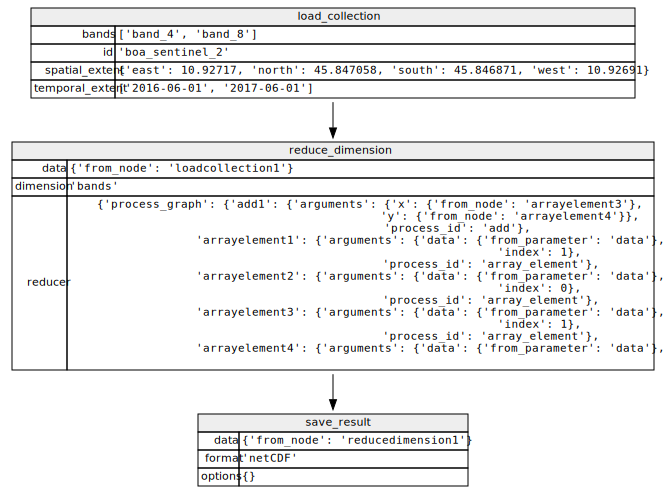

In [28]:
l2a_force.to_graphviz()

We create the batch job at the EODC back-end:

In [46]:
job_eodc_s2 = eodc_conn.create_job(l2a_force.graph)
job_id_eodc_s2 = job_eodc_s2.job_id
if job_id_eodc_s2:
    print("Batch job created with id: ",job_eodc_s2)
    job_eodc_s2.start_job()
else:
    print("Error! Job ID is None")

Batch job created with id:  jb-3dd37ae5-c346-4f7a-9071-7e4e38789efd


We check if the job has been finished.

Please run the following cell again after some time to get an updated status. You can't proceed and download the data if the job is still running.

In [47]:
eodc_conn = openeo.connect("https://openeo.eodc.eu/v1.0").authenticate_basic()
job_eodc_s2 = eodc_conn.job(job_id_eodc_s2)
job_description = job_eodc_s2.describe_job()
print("Batch job with id: ",job_id_eodc_s2, ' is ',job_description['status'])

Batch job with id:  jb-3dd37ae5-c346-4f7a-9071-7e4e38789efd  is  finished


In [ ]:
results_eodc = job_eodc_s2.get_results()
results_eodc.download_file("./data/US2/s2_eodc_force_timeseries.nc")

Now we do the same using the Landsat-8 ARD collection.

In [48]:
collection      = 'boa_landsat_8'
spatial_extent  = {'west':bbox[0],'east':bbox[2],'south':bbox[1],'north':bbox[3]}
temporal_extent = ["2016-06-01", "2017-06-01"]
bands           = ["B03","B04"]

l8_eodc = eodc_conn.load_collection(collection,spatial_extent=spatial_extent,bands=bands,temporal_extent=temporal_extent)

ndvi = l8_eodc.reduce_dimension(dimension="bands",reducer = lambda value: (array_element(value,1)-array_element(value,0))/(array_element(value,1)+array_element(value,0)))

l8_ndvi = ndvi.save_result(format="netCDF")

In [49]:
job_eodc_l8 = eodc_conn.create_job(l8_ndvi.graph)
job_id_eodc_l8 = job_eodc_l8.job_id
if job_id_eodc_l8:
    print("Batch job created with id: ",job_id_eodc_l8)
    job_eodc_l8.start_job()
else:
    print("Error! Job ID is None")

Batch job created with id:  jb-372e1c75-9b6b-485f-994e-bf4648f96d7f


In [51]:
eodc_conn = openeo.connect("https://openeo.eodc.eu/v1.0").authenticate_basic()
job_eodc_l8 = eodc_conn.job(job_id_eodc_l8)
job_description = job_eodc_l8.describe_job()
print("Batch job with id: ",job_id_eodc_l8, ' is ',job_description['status'])

Batch job with id:  jb-372e1c75-9b6b-485f-994e-bf4648f96d7f  is  finished


In [50]:
results_eodc = job_eodc_l8.get_results()
results_eodc.download_file("./data/US2/l8_eodc_timeseries.nc")

PosixPath('data/US2/l8_eodc_timeseries.nc')

We can now open the downloaded timeseries and check taht they are perfectly aligned.

You will see that x and y coordinates of the Landsat pixel are exactly the same as the center of the 3x3 grid of Sentinel-2 data.

Sentinel-2 data:

In [22]:
xr.open_dataset("./data/US2/s2_eodc_force_timeseries.nc")

<xarray.Dataset>
Dimensions:                                 (time: 42, x: 3, y: 3)
Coordinates:
  * time                                    (time) datetime64[ns] 2016-06-18T...
  * y                                       (y) float64 1.416e+06 ... 1.416e+06
  * x                                       (x) float64 4.824e+06 ... 4.824e+06
    spatial_ref                             int32 ...
Data variables:
    stack-e6f83332f3e8721f9ee35ba44643f769  (time, y, x) float64 ...

Landsat-8 data:

In [23]:
xr.open_dataset("./data/US2/l8_eodc_timeseries.nc")

<xarray.Dataset>
Dimensions:                                 (time: 34, x: 1, y: 1)
Coordinates:
  * time                                    (time) datetime64[ns] 2016-06-15T...
  * y                                       (y) float64 1.416e+06
  * x                                       (x) float64 4.824e+06
    spatial_ref                             int32 ...
Data variables:
    stack-02df068a277b2123b22a68e40f3c8502  (time, y, x) float64 ...

We can get a visualization of them with the following code.

In [24]:
s2_timeseries = xr.open_dataset("./data/US2/s2_eodc_force_timeseries.nc")
s2_timeseries = s2_timeseries.rename({next(iter(s2_timeseries.data_vars)): 'S2_NDVI'}).dropna(dim='time')
l8_timeseries = xr.open_dataset("./data/US2/l8_eodc_timeseries.nc")
l8_timeseries = l8_timeseries.rename({next(iter(l8_timeseries.data_vars)): 'L8_NDVI'}).dropna(dim='time')

In [25]:
ndvi_timeseries = s2_timeseries.mean(['x','y'], skipna=True).clip(-1,1)

ndvi_l8 = l8_timeseries.mean(['x','y'], skipna=True).clip(-1,1)
ndvi_l8 = ndvi_l8.interp_like(ndvi_timeseries)
ndvi_timeseries['L8_NDVI'] = ndvi_l8.L8_NDVI

timeseries_plot = ndvi_timeseries.hvplot.scatter(title='Timeseries of NDVI from Sentinel-2 and Landsat-8 ARD',dynamic=False,grid=True,width=800,height=300)
bounds = {'ndvi_timeseries':(-1, 1)}
timeseries_plot = timeseries_plot.redim.range(**bounds)
timeseries_plot

:NdOverlay   [Variable]
   :Scatter   [time]   (value)